 # Computational Statistics Homework 03
 Kalin Gibbons  
 2020-02-06

 ## Problem 1
 
 ---
 
 Implement iteratively reweighted least squares (IRLS) algorithm to reproduce
 the result in Example 2.5 of the *Computation Statistics* book. Note that the
 data set is available from the book's
 [webpage](http://www.stat.colostate.edu/computationalstatistics/).

 1. Print your result in the format of table 2.1, using a starting value
    $\beta^{(0)} = \left( \beta_0^{(0)}, \beta_1^{(0)} \right)^\textrm{T} =
    (0.95913, 0)^\textrm{T}$, which means $\pi_i = 775/1072$ for all $i$ at
    iteration 0.
 1. Print your result in the format of table 2.1, using a starting value
    $\beta^{(0)} = \left( \beta_0^{(0)}, \beta_1^{(0)} \right)^\textrm{T} =
    (0, 0)^\textrm{T}$, which means $\pi_i = 0.5$ for all $i$ at
    iteration 0.
 1. Making a single plot similar to Figure 2.7 showing the solution paths in
    part (1) and part (2).

In [62]:
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (15, 7.5)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22


In [63]:
# Load in the data to predictor z and class y
face_data_filepath = Path.cwd() / 'data' / 'facerecognition.dat'
face_data = pd.read_csv(face_data_filepath, sep=' ')
y = face_data['match'].to_numpy()  # might need to make 2D and transpose
z = face_data['eyediff'].to_numpy()
Z = np.vstack([np.ones_like(z), z]).transpose()


def get_pi(Z, beta):
    return ((1 + np.exp(-Z @ beta))**-1).flatten()
    # return (1 - (1 + np.exp(Z @ beta))**-1).flatten()


def get_b(pi):
    return -np.log(1 - pi).flatten()


def get_diag_weights(pi):
    pi = np.asarray(pi)
    return (pi * (1 - pi)).flatten()


def get_hessian(Z, diag_w, y, pi):
    Z = np.asarray(Z)
    diag_w = np.asarray(diag_w)
    y = np.asarray(y)
    pi = np.asarray(pi)
    return -Z.T @ np.diag(diag_w) @ Z


def get_update(beta_prev, Z, diag_w, y, pi):
    beta_prev = np.asarray(beta_prev)
    Z = np.asarray(Z)
    diag_w = np.asarray(diag_w)
    y = np.asarray(y)
    pi = np.asarray(pi)
    beta_new = (beta_prev
                # + np.linalg.inv(Z.T @ np.diag(diag_w) @ Z)
                + np.linalg.inv(-get_hessian(Z, diag_w, y, pi))
                @ (Z.T @ (y - pi)))
    return beta_new


def has_relative_convergence(x, tol=1e-6, stabilize=False):
    x = np.asarray(x)
    x_new = x[-1]
    x_prev = x[-2]
    numerator = np.linalg.norm(x_new - x_prev)
    if not stabilize:
        denominator = np.linalg.norm(x_prev - np.zeros_like(x_prev))
    else:
        denominator = np.linalg.norm(x_prev - np.zeros_like(x_prev)) + tol
    assert denominator != 0, "Division by zero."
    return numerator / denominator < tol


def log_like(Z, beta, y):
    b = get_b(get_pi(Z, beta))
    return y @ Z @ beta - b @ np.ones_like(b)


def newton_raph(Z, init_beta, y, stabilize=False):
    init_pi = get_pi(Z, init_beta)
    init_w_diag = get_diag_weights(init_pi)
    init_fish_mat = np.dstack(-get_hessian(Z, init_w_diag, y, init_pi))
    new_beta = get_update(init_beta, Z, init_w_diag, y, init_pi)
    new_fish_mat = np.dstack(-get_hessian(Z, init_w_diag, y, init_pi))
    observed_fish_mat = np.concatenate((init_fish_mat, new_fish_mat))
    beta_mat = np.vstack((init_beta, new_beta))
    while not has_relative_convergence(beta_mat, stabilize=stabilize):
        beta_prev = beta_mat[-1]
        pi = get_pi(Z, beta_prev)
        w_diag = get_diag_weights(pi)
        beta_new = get_update(beta_prev, Z, w_diag, y, pi)
        new_fish = np.dstack(-get_hessian(Z, w_diag, y, pi))
        observed_fish_mat = np.concatenate((observed_fish_mat, new_fish))
        beta_mat = np.vstack((beta_mat, beta_new))
    return beta_mat, observed_fish_mat


def get_table(beta_mat, fish_mat):
    table_dict = {'iteration': np.arange(beta_mat.shape[0]),
                  'beta': beta_mat.round(5).tolist(),
                  'var_cov': np.linalg.inv(fish_mat).round(5).tolist()}
    return pd.DataFrame(table_dict).set_index('iteration')

### Starting value of$\beta^{(0)} = \left( \beta_0^{(0)}, \beta_1^{(0)} \right)^\textrm{T} =
    (0.95913, 0)^\textrm{T}$

In [64]:
# Run the optimizations
beta_mat_a, fish_a = newton_raph(Z, np.array([0.95913, 0]), y)
get_table(beta_mat_a, fish_a)

,beta,var_cov
iteration,,
0,"[0.95913, 0.0]","[[0.01096, -0.11775], [-0.11775, 2.24637]]"
1,"[1.72029, -13.90963]","[[0.01096, -0.11775], [-0.11775, 2.24637]]"
2,"[1.75722, -13.3839]","[[0.01377, -0.14444], [-0.14444, 2.43426]]"
3,"[1.7587, -13.40003]","[[0.01399, -0.1444], [-0.1444, 2.40179]]"
4,"[1.7587, -13.40004]","[[0.014, -0.1445], [-0.1445, 2.40317]]"


This table looks close to the one in the book, which is fine because our data set is only _similar_ to the one used in the book.

 ### Starting value $\beta^{(0)} = \left( \beta_0^{(0)}, \beta_1^{(0)} \right)^\textrm{T} =
    (0, 0)^\textrm{T}$

In [65]:
beta_mat_b, fish_b = newton_raph(Z, np.array([0, 0]), y, stabilize=True)
get_table(beta_mat_b, fish_b)

,beta,var_cov
iteration,,
0,"[0.0, 0.0]","[[0.00878, -0.09434], [-0.09434, 1.79974]]"
1,"[1.50161, -11.14408]","[[0.00878, -0.09434], [-0.09434, 1.79974]]"
2,"[1.7444, -13.26669]","[[0.01246, -0.12936], [-0.12936, 2.219]]"
3,"[1.75865, -13.39957]","[[0.01391, -0.14355], [-0.14355, 2.39142]]"
4,"[1.7587, -13.40004]","[[0.014, -0.1445], [-0.1445, 2.40313]]"
5,"[1.7587, -13.40004]","[[0.014, -0.1445], [-0.1445, 2.40317]]"


This starting point took one extra iteration to find the maximum.

### A single plot similar to Figure 2.7 showing the solution paths in part (1) and part (2).

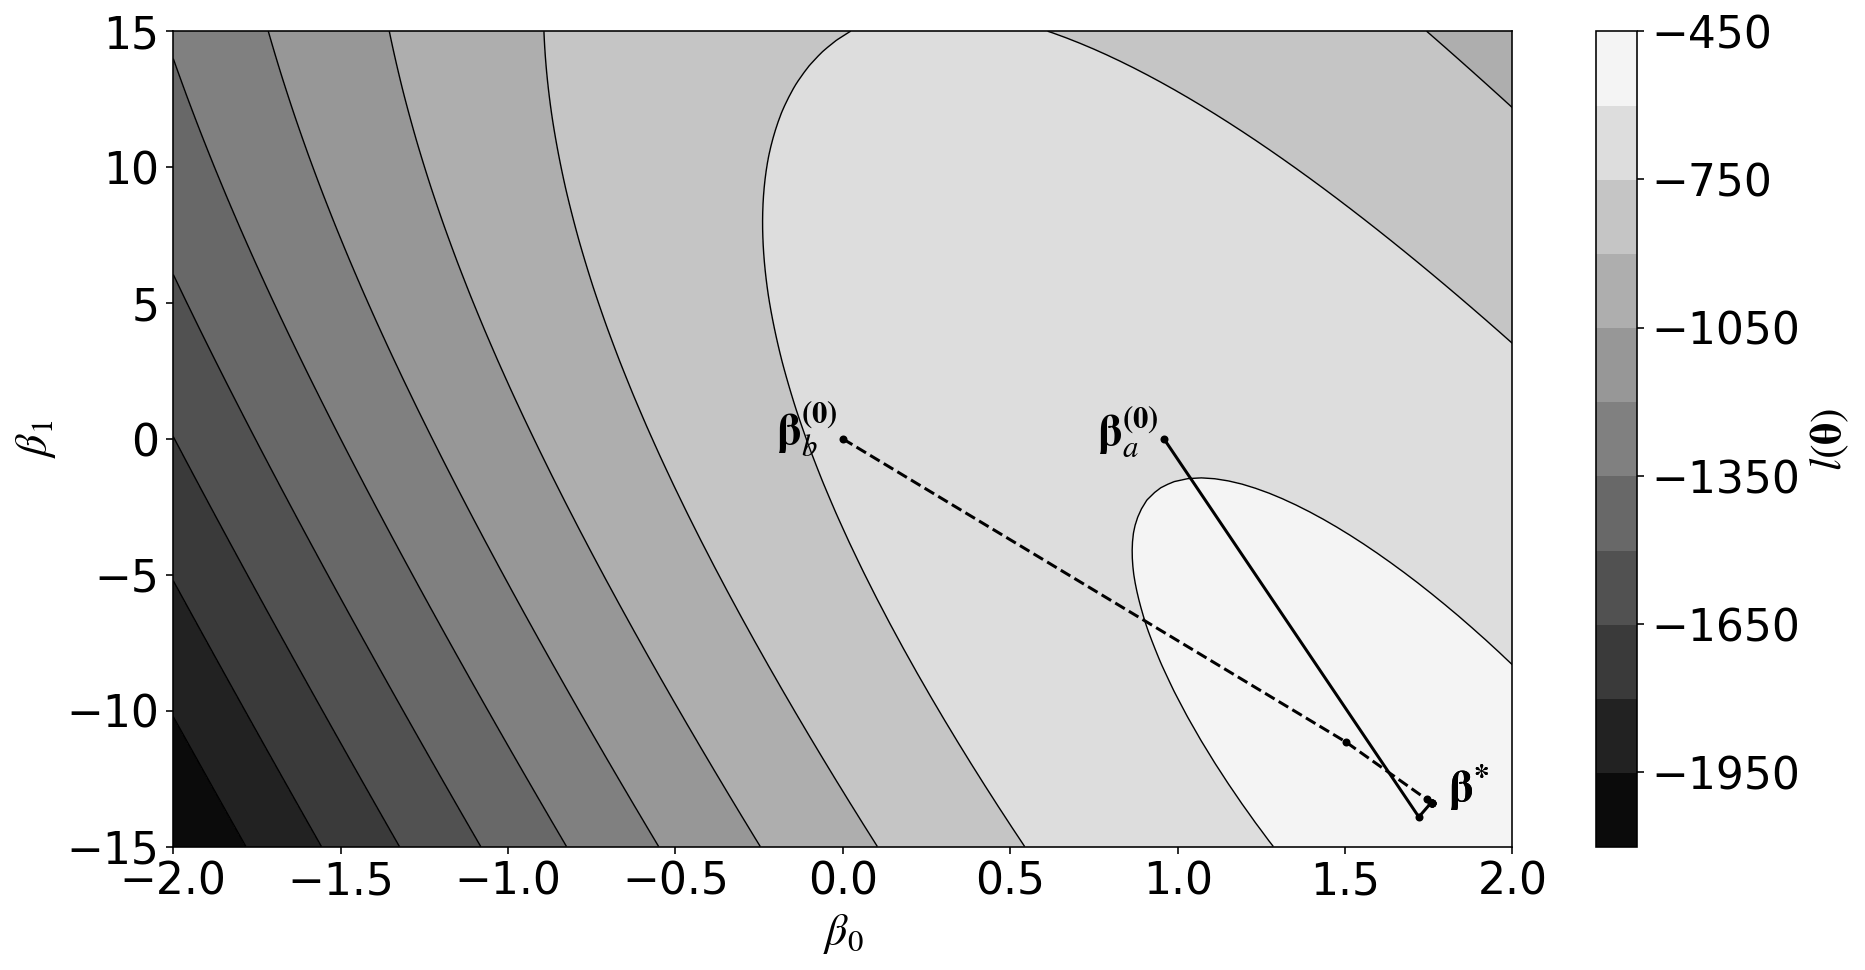

In [66]:
# Plot the log-likelihood
n_points = 100
beta_0 = np.linspace(-2, 2, n_points)
beta_1 = np.linspace(-15, 15, n_points)

bb_0, bb_1 = np.meshgrid(beta_0, beta_1)
ll = np.full_like(bb_0, np.nan, dtype=float)
for idx in range(bb_0.size):
    beta = (bb_0.flat[idx], bb_1.flat[idx])
    ll.flat[idx] = log_like(Z, beta, y)

n_lvl = 12
plt.contourf(bb_0, bb_1, ll, cmap='gray', levels=n_lvl)
plt.plot(beta_mat_a[:, 0], beta_mat_a[:, 1], '.k-', linewidth=1.5)
plt.annotate(r'$\mathbf{{\beta_\mathit{{a}}^{{(0)}}}}$',
             (beta_mat_a[0] - 0.2))
plt.annotate(r'$\mathbf{{\beta^{{*}}}}$',
             (beta_mat_a[-1] + 0.05))
plt.plot(beta_mat_b[:, 0], beta_mat_b[:, 1], '.k--', linewidth=1.5)
plt.annotate(r'$\mathbf{{\beta_\mathit{{b}}^{{(0)}}}}$',
             (beta_mat_b[0] - 0.2))
plt.annotate(r'$\mathbf{{\beta^{{*}}}}$',
             (beta_mat_b[-1] + 0.05))
cbar = plt.colorbar()
cbar.set_label(r'$l(\mathbf{{\theta}})$')
plt.contour(bb_0, bb_1, ll, colors='k', linestyles='-', levels=n_lvl,
            linewidths=0.7)
plt.xlabel(r'$\beta_0$')
plt.ylabel(r'$\beta_1$')
plt.show()

 <br>
 <br>
 
 ## Problem 2
 
---

 ### Problem 2.1

 The following data are an i.i.d. sample from a Cauchy($\theta$, 1)
 distribution 1.77, -0.23, 2.76, 3.80, 3.47, 56.75, -1.34, 4.24, -2.44, 3.29,
 3.71, -2.40, 4.53, -0.07, -1.05, -13.87, -2.43, -1.75, 0.27, 43.21.

 * (a) Graph the log likelihood function. Find the MLE for $\theta$ using the
   Newton-Raphson method. Try all of the following starting points: -11, -1,
   0, 1.5, 4, 4.7, 7, 8, and 38. Discuss your results. Is the mean of the data
   a good starting point?
 * (b) Apply the bisection method with starting points -1 and 1. Use
   additional runs to illustrate manners in which the bisection method may
   fail to find the global maximum.
 * (c) Apply fixed-point iterations as in (2.29), starting from -1, with
   scaling choices of $\alpha$ = 1, 0.64, and 0.25. Investigate other choices
   of starting values and scaling factors.
 * (d) From starting values of $\left(\theta^{(0)}, \theta^{(1)} \right) =
   (-2, -1)$, apply the secant method to estimate $\theta$. What happens
   $\left(\theta^{(0)}, \theta^{(1)} \right) = (-3, 3)$, and for other
   starting choices?
 * (e) Use this example to compare the speed and stability of the
   Newton-Raphson method, bisection, fixed-point iteration, and the secant
   method. Do your conclusions change when you apply the methods to a random
   sample of size 20 from a $N(\theta, 1)$ distribution?

In [78]:
x = np.array([1.77, -0.23, 2.76, 3.80, 3.47, 56.75, -1.34, 4.24, -2.44, 3.29,
              3.71, -2.40, 4.53, -0.07, -1.05, -13.87, -2.43, -1.75, 0.27,
              43.21])
start_newton = np.array([-11, -1, 0, 1.5, 4, 4.7, 7, 8, 38, x.mean()])
start_bisect = np.array([-1, 1, 2.5, 20])
start_fixed = np.array([-1, 1, 2.5, 20])
scale_fixed = np.array([1, 0.64, 0.25, 0.1, 0.05, 2])
start_secant = np.array([
    [-2, -1],
    [-3, +3],
    [-5, +5],
    [-8, +8]
])

n_points = 100
theta_min = -100  # start_newton.min()
theta_max = 100  # start_newton.max()
theta_dom = np.linspace(theta_min, theta_max, n_points)

def has_relative_convergence(theta_ary, tol=1e-6):
    theta_new = theta_ary[-1]
    theta_prev = theta_ary[-2]
    if theta_prev != 0:
        return np.abs((theta_new - theta_prev) / theta_prev) < tol
    else:
        return np.abs((theta_new - theta_prev) / (theta_prev + tol)) < tol


def cauchy_ll(theta_array, x):
    theta_array = np.asarray(theta_array)
    loglike = np.full_like(theta_array, np.nan, dtype=float)
    for theta, idx in zip(theta_array, range(theta_array.size)):
        loglike[idx] = np.log((np.pi * (1 + (x - theta) ** 2)) ** -1).sum()
    return loglike


def cauchy_ll_p(theta, x):
    return (2 * (x - theta) / (1 + (x - theta) ** 2)).sum()


def cauchy_ll_pp(theta, x):
    num = 2 * (theta ** 2 + x ** 2 - 2 * theta * x - 1)
    den = (theta ** 2 + x ** 2 - 2 * theta * x + 1) ** 2
    return (num / den).sum()


def normal_ll(theta_array, x):
    theta_array = np.asarray(theta_array)
    loglike = np.full_like(theta_array, np.nan, dtype=float)
    for theta, idx in zip(theta_array, range(theta_array.size)):
        loglike[idx] = (
            -0.5 * (x - theta) ** 2 - np.log(np.sqrt(2 * np.pi))
        ).sum()
    return loglike


def normal_ll_p(theta, x):
    x = np.asarray(x)
    theta = np.asarray(theta)
    return (x - theta).sum()


def normal_ll_pp(theta, x):
    return -np.ones_like(x).sum()


def newt_raph(theta_guess, x, max_iter=50,
              functions=(cauchy_ll_p, cauchy_ll_pp)):
    prime = functions[0]
    prime_prime = functions[1]
    new_theta = (theta_guess
                 - prime(theta_guess, x)
                 / prime_prime(theta_guess, x))
    theta_guess = np.append(theta_guess, new_theta)
    iter_cnt = 1
    while (iter_cnt < max_iter) & (not has_relative_convergence(theta_guess)):
        new_theta = (theta_guess[-1]
                     - prime(theta_guess[-1], x)
                     / prime_prime(theta_guess[-1], x))
        theta_guess = np.append(theta_guess, new_theta)
        iter_cnt += 1
#     if iter_cnt == max_iter:
#         print('Maximum iterations reached: newt_raph has diverged.')
    return theta_guess


def bisect(theta_guess, x, bounds, max_iter=50, function=cauchy_ll_p):
    bounds = np.asarray(bounds)
    lft_theta = bounds.min()
    rit_theta = bounds.max()
    lft_prime = function(lft_theta, x)
    rit_prime = function(rit_theta, x)
    guess_prime = function(theta_guess, x)
    prod_sign = np.sign(lft_prime * guess_prime)
    if prod_sign <= 0:
        rit_theta = theta_guess
    else:
        lft_theta = theta_guess
    new_theta_guess = np.array([lft_theta, rit_theta]).mean()
    theta_guess = np.append(theta_guess, new_theta_guess)
    iter_cnt = 1
    while (iter_cnt < max_iter) & (not has_relative_convergence(theta_guess)):
        lft_prime = function(lft_theta, x)
        rit_prime = function(rit_theta, x)
        guess_prime = function(theta_guess[-1], x)
        prod_sign = np.sign(lft_prime * guess_prime)
        if prod_sign <= 0:
            rit_theta = theta_guess[-1]
        else:
            lft_theta = theta_guess[-1]
        new_theta_guess = np.array([lft_theta, rit_theta]).mean()
        theta_guess = np.append(theta_guess, new_theta_guess)
        iter_cnt += 1
#     if iter_cnt == max_iter:
#         print('Maximum iterations reached: bisect has diverged.')
    return theta_guess


def fixed_point(theta_guess, x, scalar=1, max_iter=1e3, function=cauchy_ll_p):
    theta_guess = np.asarray(theta_guess)
    prime = function
    theta_new = theta_guess + scalar * prime(theta_guess, x)
    theta_guess = np.append(theta_guess, theta_new)
    iter_cnt = 1
    while ((iter_cnt < max_iter)
           & (not has_relative_convergence(theta_guess, tol=1e-4))):
        old_settings = np.seterr(all='ignore')
        theta_new = theta_guess[-1] + scalar * prime(theta_guess[-1], x)
        theta_guess = np.append(theta_guess, theta_new)
        if abs(theta_new) == float('inf'):
            np.seterr(**old_settings)
            return theta_guess
        iter_cnt += 1
#     if iter_cnt == max_iter:
#         print(
#             f'Maximum iterations reached ({iter_cnt}) fixed_point diverged.'
#         )
    return theta_guess


def secant(theta_guess, x, max_iter=50, function=cauchy_ll_p):
    prime = function

    def prime_prime(theta_ary, x):
        theta_new = theta_ary[-1]
        theta_prev = theta_ary[-2]
        num = (prime(theta_new, x) - prime(theta_prev, x))
        den = theta_new - theta_prev
        return num / den

    iter_cnt = 1
    while (iter_cnt < max_iter) & (not has_relative_convergence(theta_guess)):
        new_theta = (theta_guess[-1]
                     - prime(theta_guess[-1], x)
                     / prime_prime(theta_guess, x))
        theta_guess = np.append(theta_guess, new_theta)
        iter_cnt += 1
#     if iter_cnt == max_iter:
#         print('Maximum iterations reached: newt_raph has diverged.')
    return theta_guess
    pass


def run_optimization(functions=(cauchy_ll, cauchy_ll_p, cauchy_ll_pp)):
    # Make the plot
    loglike = functions[0]
    prime = functions[1]
    prime_prime = functions[2]

    plt.figure()
    plt.plot(theta_dom, loglike(theta_dom, x), color='k')
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$l(\theta)$')
    if 'cauchy' in loglike.__name__:
        plt.legend(['Cauchy'])
    else:
        plt.legend(['Normal'])

    # Newton's Method
    newtdf = pd.DataFrame()
    for theta in start_newton:
        guess_ary = newt_raph(theta, x, functions=(prime, prime_prime))
        summary_dict = {'optimal_theta': guess_ary[-1],
                        'iterations': guess_ary.size}
        currdf = pd.DataFrame(summary_dict, index=[theta])
        newtdf = newtdf.append(currdf)
    newtdf.index.rename('initial', inplace=True)
    print(f'Newton Raphson:\n{newtdf}\n\n\n')

    # Bisection Method
    bisectdf = pd.DataFrame()
    for theta in start_bisect:
        guess_ary = bisect(theta, x, (theta_min, theta_max), function=prime)
        summary_dict = {'optimal_theta': guess_ary[-1],
                        'iterations': guess_ary.size}
        currdf = pd.DataFrame(summary_dict, index=[theta])
        bisectdf = bisectdf.append(currdf)
    bisectdf.index.rename('initial', inplace=True)
    print(f'Bisection:\n{bisectdf}\n\n\n')

    # Fixed Point Iteration
    fixdf = pd.DataFrame()
    for theta in start_fixed:
        for alpha in scale_fixed:
            guess_ary = fixed_point(theta, x, scalar=alpha, function=prime)
            summary_dict = {'alpha': alpha, 'optimal_theta': guess_ary[-1],
                            'iterations': guess_ary.size}
            currdf = pd.DataFrame(summary_dict, index=[theta])
            fixdf = fixdf.append(currdf)
    fixdf.index.rename('initial', inplace=True)
    print(f'Fixed Point:\n{fixdf}\n\n\n')

    # Secant method
    secantdf = pd.DataFrame()
    for theta_interval in start_secant:
        guess_ary = secant(theta_interval, x, max_iter=50, function=prime)
        summary_dict = {'optimal_theta': guess_ary[-1],
                        'iterations': guess_ary.size}
        currdf = pd.DataFrame(summary_dict, index=[theta_interval])
        secantdf = secantdf.append(currdf)
    secantdf.index.rename('initial', inplace=True)
    print('Two rows for each starting vector.')
    print(f'Secant:\n{secantdf}\n\n\n')

Newton Raphson:
         optimal_theta  iterations
initial                           
-11.000  -7.057246e+15          51
-1.000   -1.993894e-01           6
 0.000   -1.993894e-01           5
 1.500    1.724452e+00           6
 4.000    2.814537e+00           6
 4.700   -1.993894e-01           7
 7.000    4.104126e+01          10
 8.000   -3.350895e+15          51
 38.000   4.279529e+01           6
 5.111    5.625330e+01          11



Bisection:
         optimal_theta  iterations
initial                           
-1.0          2.814537          27
 1.0         -0.199389          30
 2.5          2.814538          27
 20.0        -0.199389          31



Fixed Point:
         alpha  optimal_theta  iterations
initial                                  
-1.0      1.00      -0.580231        1001
-1.0      0.64      -0.199399         235
-1.0      0.25      -0.199394          10
-1.0      0.10      -0.199421          30
-1.0      0.05      -0.199497          57
-1.0      2.00     -13.220642 

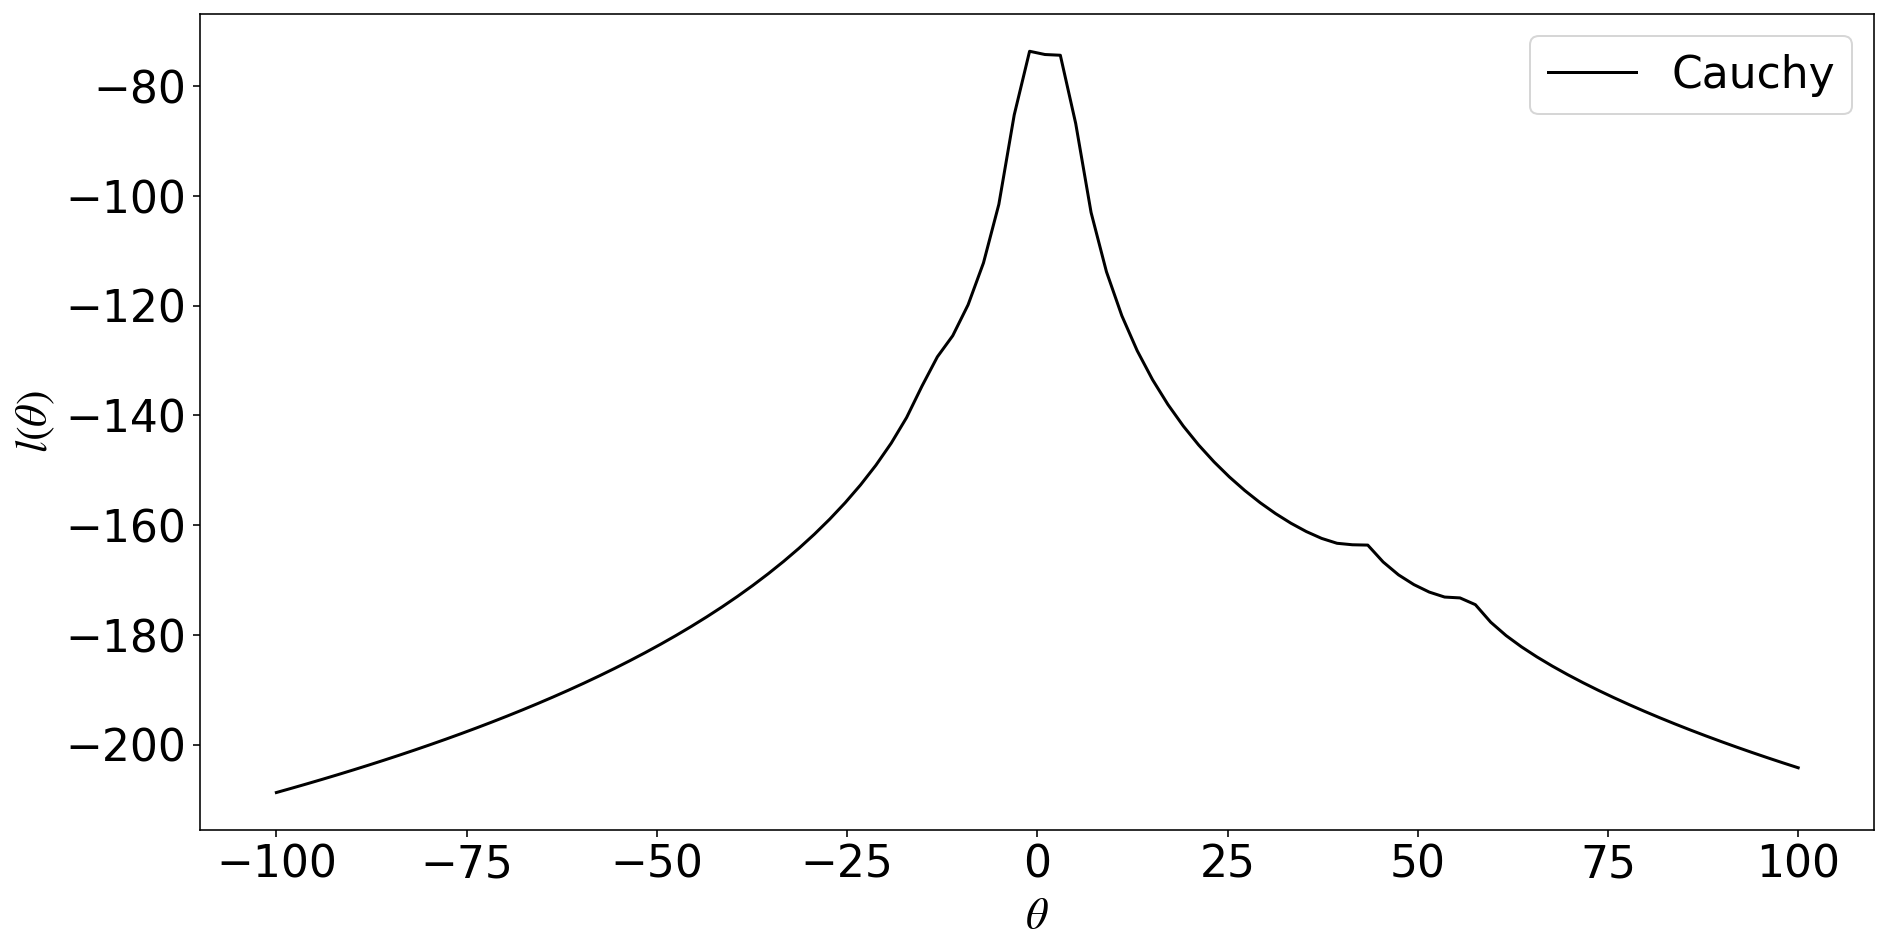

In [79]:
run_optimization(functions=(cauchy_ll, cauchy_ll_p, cauchy_ll_pp))

 * (a) Graph the log likelihood function. Find the MLE for $\theta$ using the
   Newton-Raphson method. Try all of the following starting points: -11, -1,
   0, 1.5, 4, 4.7, 7, 8, and 38. Discuss your results. Is the mean of the data
   a good starting point?
   
   _The global maximum was only found by 3 of the runs, and all of them were initialized to values    smaller than the sample mean. The most negative initial value (-11) diverged towards negative infinity. The sample mean was not a good choice._
   
   
 * (b) Apply the bisection method with starting points -1 and 1. Use
   additional runs to illustrate manners in which the bisection method may
   fail to find the global maximum.
   
   _The biection algorithm worked fairly well for these start points, finding the global maximum and the one nearest to it._
   
   
 * (c) Apply fixed-point iterations as in (2.29), starting from -1, with
   scaling choices of $\alpha$ = 1, 0.64, and 0.25. Investigate other choices
   of starting values and scaling factors.
   
   _Any of the entries that went for 1001 iterations were cut off by my limiting settings, but the majority of choices were able to find either the global maximum, or nearest local maximum_
   
   
 * (d) From starting values of $\left(\theta^{(0)}, \theta^{(1)} \right) =
   (-2, -1)$, apply the secant method to estimate $\theta$. What happens
   $\left(\theta^{(0)}, \theta^{(1)} \right) = (-3, 3)$, and for other
   starting choices?
   
   _The secant method found the global maximum for two of four runs, and got close to the global maximum for the others._

Newton Raphson:
         optimal_theta  iterations
initial                           
-11.000      40.162128           3
-1.000       40.162128           3
 0.000       40.162128           3
 1.500       40.162128           3
 4.000       40.162128           3
 4.700       40.162128           3
 7.000       40.162128           3
 8.000       40.162128           3
 38.000      40.162128           3
 5.111       40.162128           3



Bisection:
         optimal_theta  iterations
initial                           
-1.0         40.162126          23
 1.0         40.162142          23
 2.5         40.162143          23
 20.0        40.162163          22



Fixed Point:
         alpha  optimal_theta  iterations
initial                                  
-1.0      1.00           -inf         237
-1.0      0.64           -inf         281
-1.0      0.25            inf         488
-1.0      0.10  -1.016677e+43        1001
-1.0      0.05   4.016214e+01           6
-1.0      2.00            inf 

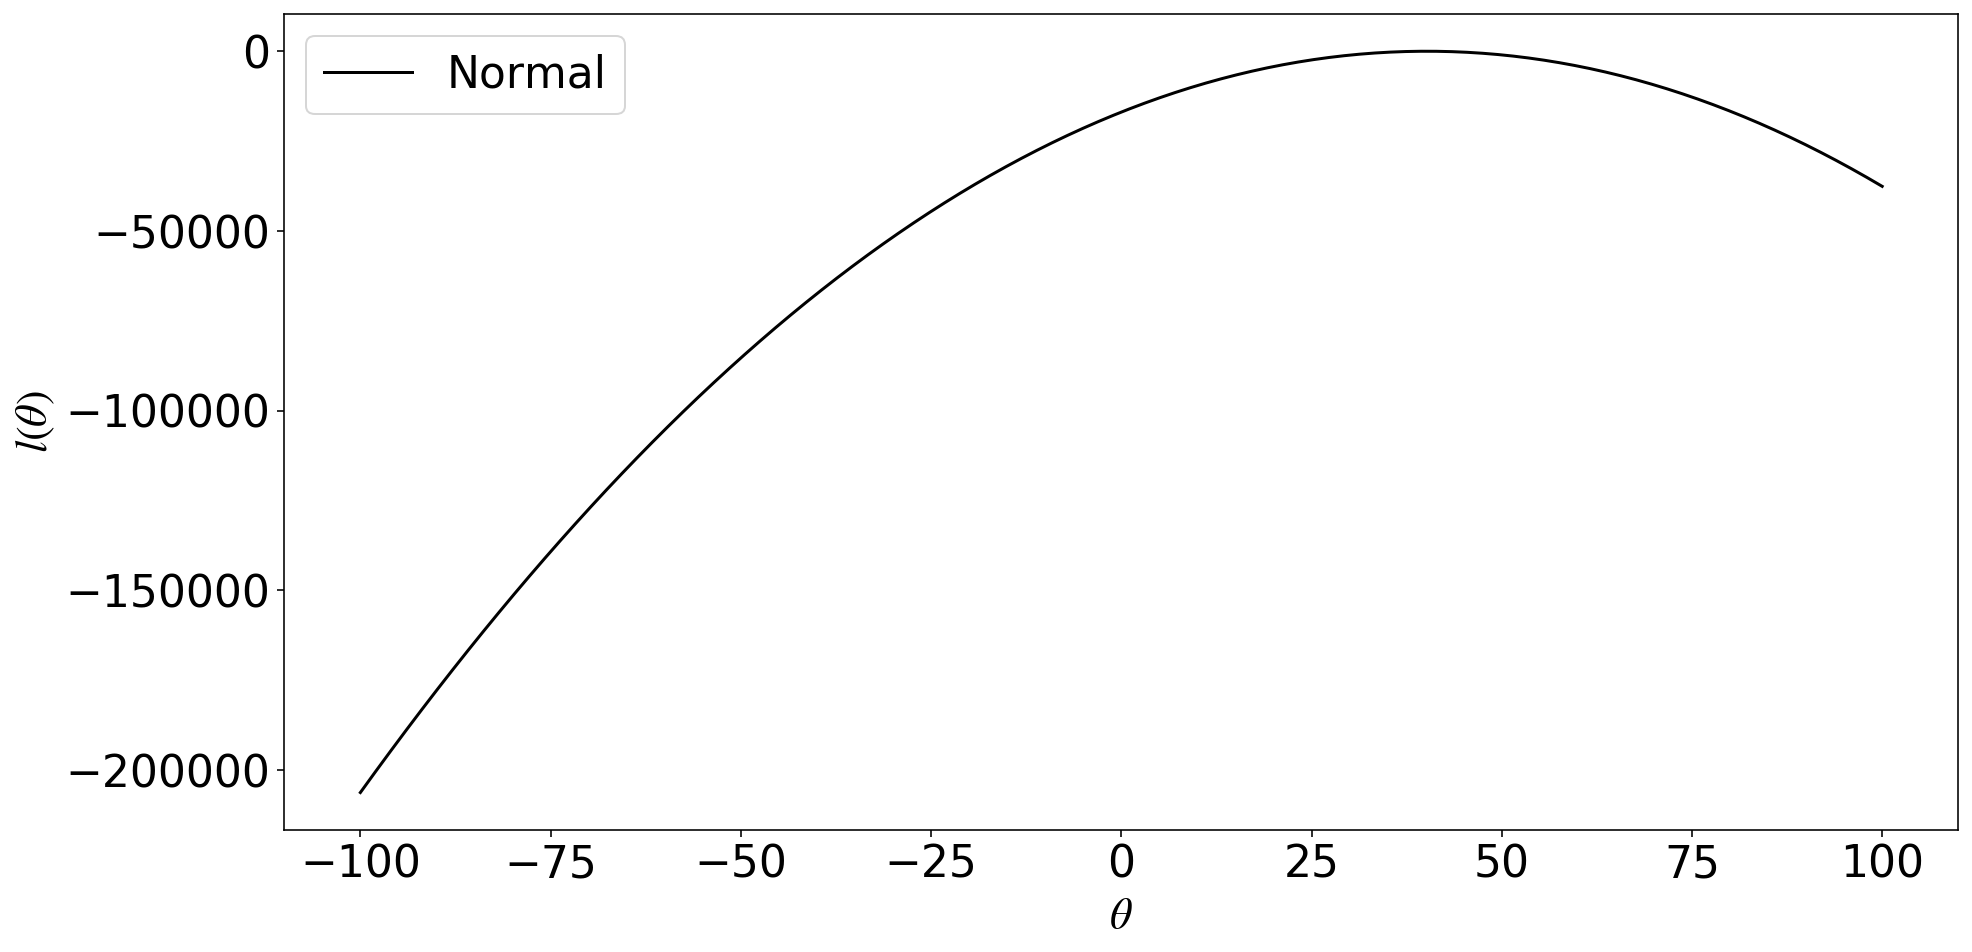

In [69]:
x = np.random.normal(40, 1, x.size)
x = np.append(x, x.mean())
run_optimization(functions=(normal_ll, normal_ll_p, normal_ll_pp))

* (e) Use this example to compare the speed and stability of the
   Newton-Raphson method, bisection, fixed-point iteration, and the secant
   method. Do your conclusions change when you apply the methods to a random
   sample of size 20 from a $N(\theta, 1)$ distribution?
   
   _Newton-Raphson and Secant method were easily the best performers for the normal distribution, which makes sense because of how smooth the log-likelihood function is. The fixed-point iteration scheme was the most likely to diverge or reach the iteration limits in both cases. If one is using this method on a computationally expensive function, then they should invest the time to ensure an $\alpha$ value that makes the optimization contractive. The bisection algorithm took fairly long to converge, but did not have any issues with stability_

 ## Problem 3

 Problem 2.4 on page 56 of the *Computation Statistics* book. Required output:
 a single plot including
 1. the Gamma(2,1) probability density
 1. the lower and upper end of the interval clearly marked on the $x$-axis
 1. the region under the density curve and above the between the 95% highest
    posterior density interval

 ### Problem 2.4

 A parameter $\theta$ has a Gamma(2, 1) posterior distribution. Find the 95%
 highest posterior density interval for $\theta$, that is, the interval
 containing 95% of the posterior probability for which the posterior density
 for every point contained in the interval is never lower than the density for
 every point outside the interval. Since the gamma density is unimodal, the
 interval is also the narrowest possible interval containing 95% of the
 posterior probability

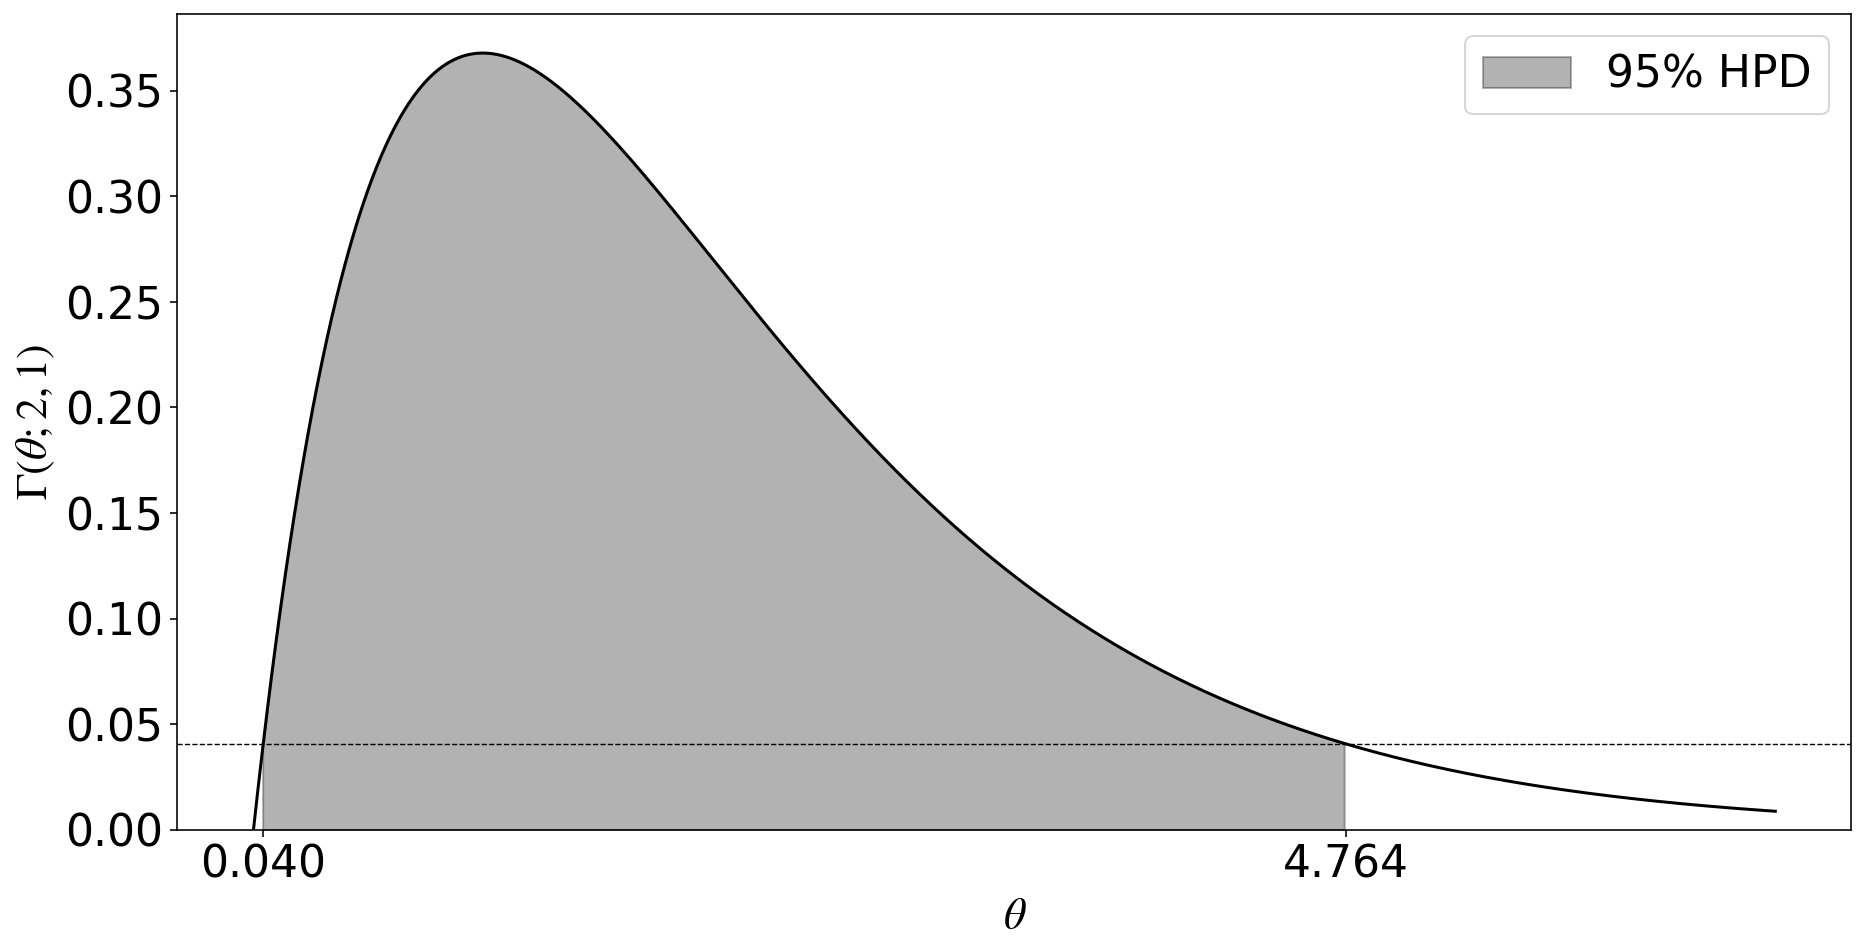

In [42]:
# Find (theta*, f*) using max and argmax of scipy.stats.gamma.pdf(theta_ary)
a = 2
n_points = int(1e3)
area = 0
theta_array = np.linspace(stats.gamma.ppf(0.00, a), stats.gamma.ppf(0.99, a),
                          n_points)
gam = stats.gamma.pdf(theta_array, a)
gam_max = gam.max()
gam_max_idx = gam.argmax()
lft_interval = theta_array[:gam_max_idx]
rit_interval = theta_array[gam_max_idx:]

# Define the line as f* - i * step_size
step_sz = 1e-4 * gam_max
alph = 1
while area < 0.95:
    y_intcpt = gam_max - alph * step_sz

    # Locate the interval [a, b] using argmin of abs(f - (f* - i * step_size))
    #   Will have to do argmin of the f array, and the reversed f array
    lft_delta = np.abs(stats.gamma.pdf(lft_interval, a) - y_intcpt)
    rit_delta = np.abs(stats.gamma.pdf(rit_interval, a) - y_intcpt)
    lft_a_idx = lft_delta.argmin()
    rit_b_idx = lft_interval.size + rit_delta.argmin()
    lft_a = theta_array[lft_a_idx]
    rit_b = theta_array[rit_b_idx]

    # Calculate the area using scipy.stats.gamma.cdf(b) - ...cdf(a)
    area = stats.gamma.cdf(rit_b, a) - stats.gamma.cdf(lft_a, a)
    alph += 1

    
# Make the plot
fig = plt.figure()
plt.plot(theta_array, gam, 'k')
plt.fill_between(
    theta_array[lft_a_idx:rit_b_idx],
    gam[lft_a_idx:rit_b_idx],
    alpha=0.3,
    color='k',
    label='95% HPD'
)
ln_wid = 0.7
plt.axhline(y_intcpt, color='k', linestyle='--', linewidth=ln_wid)
ax = plt.gca()
ax.set_ylim((0, ax.get_ylim()[1]))
ax.set_xticks((lft_a, rit_b))
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\Gamma(\theta ; 2, 1)$')
plt.legend()
plt.show()

 ## Problem 4

 Observations $Y_1, \dots, Y_n$ are described by the relationship $Y_i =
 \theta x_i^2 + \epsilon_i$, where $x_1, \dots, x_n$ are fixed constants and
 $\epsilon_1, \dots, \epsilon_n$ are iid $N(0, \sigma^2)$.

 1. Find the least squares estimator of $\theta$.
 1. Find the MLE of \theta.
 
> _I didn't have enough time to do this one in LaTeX. See the attached pdf._